In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt


In [4]:
spark = SparkSession.builder.appName("GenderInequality").getOrCreate()


In [5]:
gender_inequality_data = spark.read.csv("Gender_Inequality_Index.csv", header=True, inferSchema=True)


In [6]:
# Display the first set of rows from the dataset

In [7]:
gender_inequality_data.show(30)

+--------------------+-----------------+-----+----+------------------+---------------------+----------------+----------------+----------------+--------------+--------------+
|             Country|Human_development|  GII|Rank|Maternal_mortality|Adolescent_birth_rate|Seats_parliament|F_secondary_educ|M_secondary_educ|F_Labour_force|M_Labour_force|
+--------------------+-----------------+-----+----+------------------+---------------------+----------------+----------------+----------------+--------------+--------------+
|         Switzerland|        Very high|0.018|   3|                 5|                  2.2|            39.8|            96.9|            97.5|          61.7|          72.7|
|              Norway|        Very high|0.016|   2|                 2|                  2.3|            45.0|            99.1|            99.3|          60.3|          72.0|
|             Iceland|        Very high|0.043|   8|                 4|                  5.4|            47.6|            99.8|    

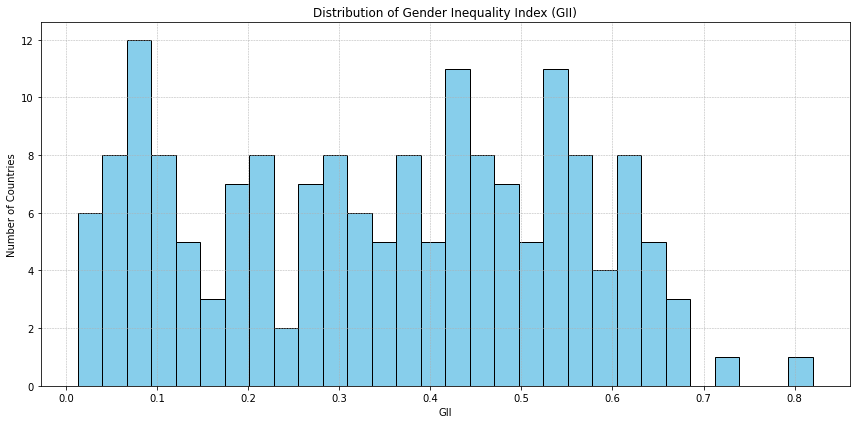

In [8]:
# GII 
gii_values = gender_inequality_data.select("GII").na.drop().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.hist(gii_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Gender Inequality Index (GII)')
plt.xlabel('GII')
plt.ylabel('Number of Countries')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

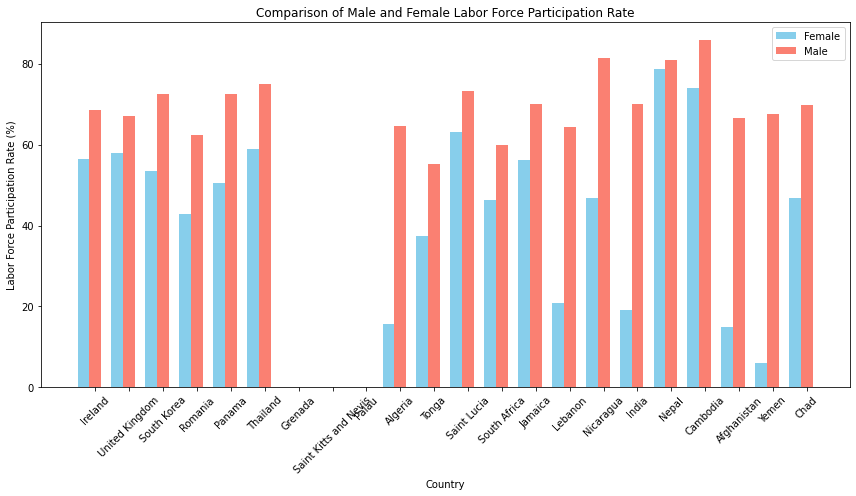

In [9]:
# 10 random countries
countries_sample = gender_inequality_data.sample(False, 0.1, 42).toPandas()

plt.figure(figsize=(12, 7))
bar_width = 0.35
index = range(len(countries_sample))
plt.bar(index, countries_sample['F_Labour_force'], bar_width, label='Female', color='skyblue')
plt.bar([i + bar_width for i in index], countries_sample['M_Labour_force'], bar_width, label='Male', color='salmon')
plt.xlabel('Country')
plt.ylabel('Labor Force Participation Rate (%)')
plt.title('Comparison of Male and Female Labor Force Participation Rate')
plt.xticks([i + bar_width for i in index], countries_sample['Country'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 864x504 with 0 Axes>

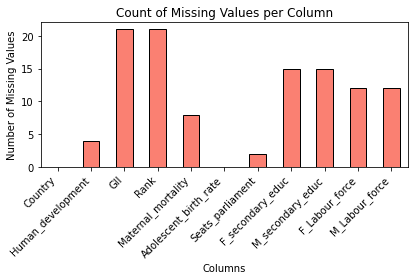

In [10]:
# conculate the missing value
missing_values_count = gender_inequality_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in gender_inequality_data.columns]).toPandas().transpose()

plt.figure(figsize=(12, 7))
missing_values_count.plot(kind='bar', color='salmon', edgecolor='black', legend=None)
plt.title('Count of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
# 转换 "Human_development" 列为数值序数值
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

ordinal_mapping = {'Very high': 4, 'High': 3, 'Medium': 2, 'Low': 1}
ordinal_udf = udf(lambda x: ordinal_mapping.get(x), IntegerType())
gender_inequality_data = gender_inequality_data.withColumn('HDI_ordinal', ordinal_udf(col('Human_development')))

In [12]:
from pyspark.sql.types import DoubleType, FloatType, IntegerType

# 获取所有数值类型列
numeric_columns = [field.name for field in gender_inequality_data.schema.fields if isinstance(field.dataType, (DoubleType, FloatType, IntegerType))]

# 从数值类型列中排除 'Rank' 和 'HDI_ordinal'
columns_to_correlate = [column for column in numeric_columns if column != 'Rank' and column != 'HDI_ordinal']

correlation_with_HDI_ordinal = []

for column in columns_to_correlate:
    correlation_value = gender_inequality_data.stat.corr(column, 'HDI_ordinal')
    correlation_with_HDI_ordinal.append((column, correlation_value))
    
correlation_with_HDI_ordinal = sorted(correlation_with_HDI_ordinal, key=lambda x: x[1])


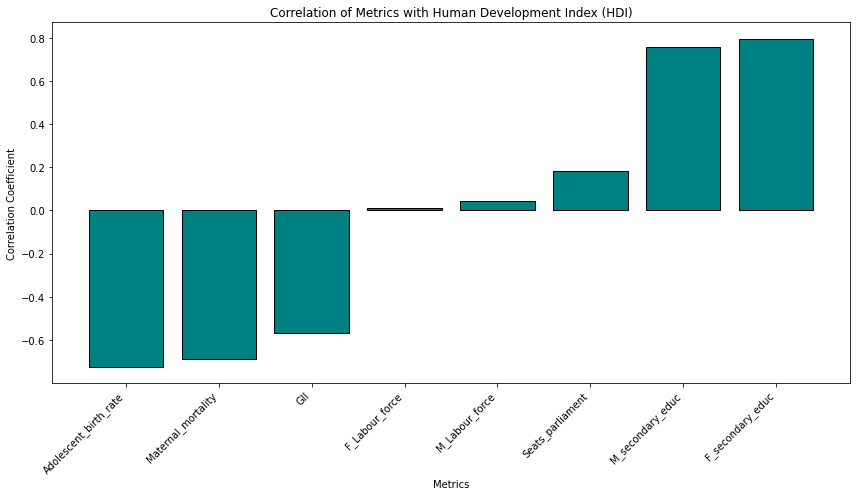

In [13]:
# 创建条形图以可视化相关性
columns, correlation_values = zip(*correlation_with_HDI_ordinal)

plt.figure(figsize=(12, 7))
plt.bar(columns, correlation_values, color='teal', edgecolor='black')
plt.title('Correlation of Metrics with Human Development Index (HDI)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:

from pyspark.sql.functions import mean, col, when, count, isnan, udf, initcap
from pyspark.sql.window import Window
import seaborn as sns
# 1. Handling missing values for numeric columns
numerical_columns = [f.name for f in gender_inequality_data.schema.fields if isinstance(f.dataType, (FloatType, DoubleType))]

for column in numerical_columns:
    for level in ['Very high', 'High', 'Medium', 'Low']:
        mean_value = gender_inequality_data.filter(col("Human_development") == level).agg(mean(column)).first()[0]
        gender_inequality_data = gender_inequality_data.withColumn(column, when((col("Human_development") == level) & (col(column).isNull()), mean_value).otherwise(col(column)))


In [15]:
# 2. Identify and handle outliers
original_data_pd = gender_inequality_data.select(numerical_columns).toPandas()
for column in numerical_columns:
    quantiles = gender_inequality_data.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mean_value = gender_inequality_data.agg(mean(column)).first()[0]
    gender_inequality_data = gender_inequality_data.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), mean_value).otherwise(col(column)))


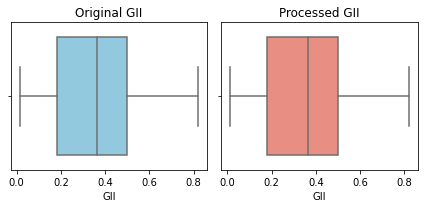

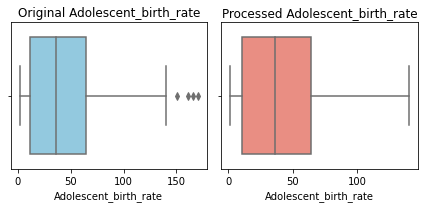

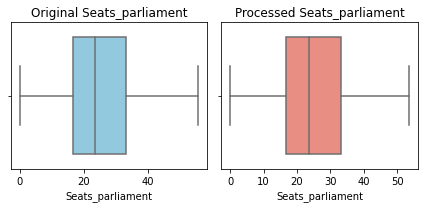

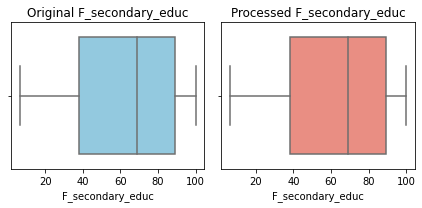

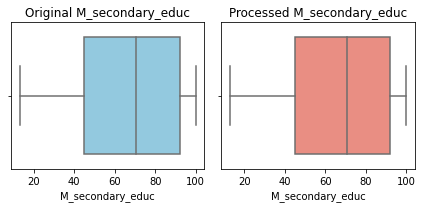

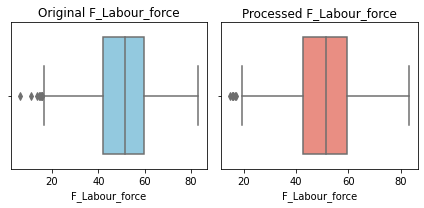

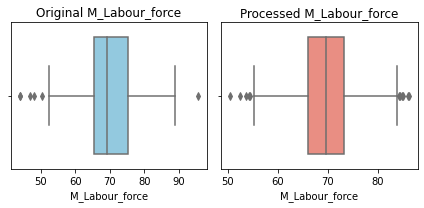

In [16]:
# Convert processed data to Pandas DataFrame for visualization
processed_data_pd = gender_inequality_data.select(numerical_columns).toPandas()

# Plot the data before and after processing
for column in numerical_columns:
    plt.figure(figsize=(6, 3))
    
    # original_data_pd
    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_data_pd[column], color='skyblue')
    plt.title(f'Original {column}')
    
    # processed_data_pd
    plt.subplot(1, 2, 2)
    sns.boxplot(x=processed_data_pd[column], color='salmon')
    plt.title(f'Processed {column}')
    
    plt.tight_layout()
    plt.show()


In [17]:
# 3. 处理数据不一致性
gender_inequality_data = gender_inequality_data.withColumn("Country", initcap(col("Country")))

# 构造新的特征
gender_inequality_data = gender_inequality_data.withColumn("Education_Disparity_Ratio", col("M_secondary_educ") / col("F_secondary_educ"))
gender_inequality_data = gender_inequality_data.withColumn("Workforce_Disparity_Ratio", col("M_Labour_force") / col("F_Labour_force"))

# 将 PySpark DataFrame 转换为 Pandas DataFrame 进行可视化
gender_inequality_data_pd = gender_inequality_data.toPandas()
print(gender_inequality_data.toPandas().head(10))


       Country Human_development       GII  Rank  Maternal_mortality  \
0  Switzerland         Very high  0.018000   3.0                 5.0   
1       Norway         Very high  0.016000   2.0                 2.0   
2      Iceland         Very high  0.043000   8.0                 4.0   
3    Hong Kong         Very high  0.147032   NaN                 NaN   
4    Australia         Very high  0.073000  19.0                 6.0   
5      Denmark         Very high  0.013000   1.0                 4.0   
6       Sweden         Very high  0.023000   4.0                 4.0   
7      Ireland         Very high  0.074000  21.0                 5.0   
8      Germany         Very high  0.073000  19.0                 7.0   
9  Netherlands         Very high  0.025000   5.0                 5.0   

   Adolescent_birth_rate  Seats_parliament  F_secondary_educ  \
0                    2.2         39.800000              96.9   
1                    2.3         45.000000              99.1   
2              

In [18]:
# 设置 Seaborn 样式
sns.set_style("whitegrid")

# Plot the distribution of new features
plt.figure(figsize=(14, 6))


<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

Text(0, 0.5, 'Number of Countries')

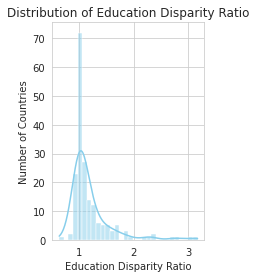

In [19]:
# Educational difference ratio distribution
plt.subplot(1, 2, 1)
sns.histplot(gender_inequality_data_pd['Education_Disparity_Ratio'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Education Disparity Ratio')
plt.xlabel('Education Disparity Ratio')
plt.ylabel('Number of Countries')

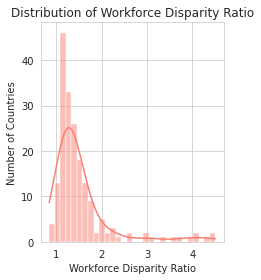

In [20]:
# Labor force difference ratio distribution
plt.subplot(1, 2, 2)
sns.histplot(gender_inequality_data_pd['Workforce_Disparity_Ratio'], bins=30, color='salmon', kde=True)
plt.title('Distribution of Workforce Disparity Ratio')
plt.xlabel('Workforce Disparity Ratio')
plt.ylabel('Number of Countries')

plt.tight_layout()
plt.show()

In [21]:
hdi_data = spark.read.csv("HDI-1997-2019.csv", header=True, inferSchema=True)
rate_data = spark.read.csv("rate_1997-2019.csv", header=True, inferSchema=True)
merged_data = hdi_data.join(rate_data, ["Country Name", "Year"], "outer")
merged_data.show(50)

+------------+--------+-----+------+------+----------+-----------+-----------+
|Country Name|    Year|  hdi|lfpr_f|lfpr_m|      se_f|       se_m|  seat_rate|
+------------+--------+-----+------+------+----------+-----------+-----------+
| Afghanistan|1997/1/1|0.323|14.954|76.262| 1.1829055| 6.44923533|       null|
| Afghanistan|1998/1/1|0.324|14.873|76.415|1.24442633|  6.5542821|       null|
| Afghanistan|1999/1/1|0.332|14.827|76.549|1.30594716| 6.65932888|       null|
| Afghanistan|2000/1/1|0.335|14.795|76.646|1.36746799| 6.76437565|       null|
| Afghanistan|2001/1/1|0.337|14.936|76.589|1.47649996| 7.18376694|       null|
| Afghanistan|2002/1/1|0.362|15.113|76.491|1.58553193| 7.60315823|       null|
| Afghanistan|2003/1/1|0.376|15.298|76.393| 1.6945639| 8.02254952|       null|
| Afghanistan|2004/1/1|0.392|15.475|76.332|1.80359587| 8.44194082|       null|
| Afghanistan|2005/1/1|  0.4|15.644|76.318|1.91262783| 8.86133211|25.92592593|
| Afghanistan|2006/1/1|0.409|15.455|76.422|1.8876540

In [26]:
# Convert 'Year' column to integer format:
from pyspark.sql.functions import mean, col, when, last, first
from pyspark.sql.window import Window
merged_data = merged_data.withColumn("Year", col("Year").cast("int"))

# Handle missing values using forward fill:
window_spec = Window.partitionBy("Country Name").orderBy("Year")

# Excluding the 'Country Name' and 'Year' columns from the forward and backward fill operations
columns_to_process = [column for column in merged_data.columns if column not in ["Country Name", "Year"]]

for column in columns_to_process:
    merged_data = merged_data.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(last(col(column), True).over(window_spec)))

# If there are still any missing values, we can backward fill:
for column in columns_to_process:
    merged_data = merged_data.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(first(col(column), True).over(window_spec)))

merged_data.show(50)

+------------+----+-----+------+------+----------+-----------+-----------+
|Country Name|Year|  hdi|lfpr_f|lfpr_m|      se_f|       se_m|  seat_rate|
+------------+----+-----+------+------+----------+-----------+-----------+
| Afghanistan|null|0.323|14.954|76.262| 1.1829055| 6.44923533|27.24358974|
| Afghanistan|null|0.324|14.873|76.415|1.24442633|  6.5542821|27.24358974|
| Afghanistan|null|0.332|14.827|76.549|1.30594716| 6.65932888|27.24358974|
| Afghanistan|null|0.335|14.795|76.646|1.36746799| 6.76437565|27.24358974|
| Afghanistan|null|0.337|14.936|76.589|1.47649996| 7.18376694|27.24358974|
| Afghanistan|null|0.362|15.113|76.491|1.58553193| 7.60315823|27.24358974|
| Afghanistan|null|0.376|15.298|76.393| 1.6945639| 8.02254952|27.24358974|
| Afghanistan|null|0.392|15.475|76.332|1.80359587| 8.44194082|27.24358974|
| Afghanistan|null|  0.4|15.644|76.318|1.91262783| 8.86133211|25.92592593|
| Afghanistan|null|0.409|15.455|76.422|1.88765403| 9.45898459|25.92592593|
| Afghanistan|null|0.424|